In [1]:
# I am using 3.9.7.
import sys
print("Python Version is: " + sys.version)

Python Version is: 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

#SNS Settings 
sns.set(color_codes = True)
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(7,4)})
sns.set_palette("Set3")

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

In [3]:
# Importing dataset
import time
time_begin = time.time()

df = pd.read_csv("CleanedDF.csv")

print(f'Run time: {round(((time.time()-time_begin)/60), 3)} mins') 

Run time: 0.003 mins


In [4]:
# notice that date is an object dtype, not datetime64
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_details_id  48620 non-null  int64  
 1   order_id          48620 non-null  int64  
 2   pizza_id          48620 non-null  object 
 3   quantity          48620 non-null  int64  
 4   date              48620 non-null  object 
 5   time              48620 non-null  object 
 6   pizza_type_id     48620 non-null  object 
 7   size              48620 non-null  object 
 8   price             48620 non-null  float64
 9   name              48620 non-null  object 
 10  category          48620 non-null  object 
 11  ingredients       48620 non-null  object 
 12  items_0           48620 non-null  object 
 13  items_1           48620 non-null  object 
 14  items_2           48620 non-null  object 
 15  items_3           48620 non-null  object 
 16  items_4           48620 non-null  object

In [5]:
# Changing size into a category
df['size']=df['size'].astype('category')


# set and order categories for size
df["size"] = df["size"].cat.set_categories(["S", "M", "L", "XL","XXL"], ordered=True)

In [6]:
df['size'].value_counts(sort = False)
# Sort must be set to False.
# This does not sort by the quantity within each size, rather by the size order I created above.

S      14137
M      15385
L      18526
XL       544
XXL       28
Name: size, dtype: int64

In [7]:
# Taking date and time and joining them into 1 category
df['date'] = df[['date', 'time']].agg(' '.join, axis = 1)

In [8]:
# Converting date from object into datetime dtype
df['date'] = pd.to_datetime(df['date'])

In [9]:
# Represent month in date field as its first day
df['date'] = df['date'].dt.year.astype('str') + '-' + df['date'].dt.month.astype('str') + '-01'

# Converting back into datetime 
df['date'] = pd.to_datetime(df['date']) 

### Creating new dataframes

In [10]:
# Groupby date and count of transactions into a new dataframe
ta = df.groupby('date').order_details_id.count().reset_index()

# Renaming the column 
ta=ta.rename(columns={'order_details_id':'transactioncount'})

ta.head(2)

,date,transactioncount
0,2015-01-01,4156
1,2015-02-01,3892


In [11]:
# Groupby date and sum of pizzas sold into a new dataframe
quantitysold = df.groupby('date').quantity.sum().reset_index()

quantitysold.head(2)

,date,quantity
0,2015-01-01,4232
1,2015-02-01,3961


In [12]:
# Creating a new dataframe
temp1 = df.groupby([df['date'],'size']).agg(pizzasizecount= ('quantity','sum'), ordercount=('order_details_id','count'))\
.reset_index().sort_values(by=['date','size'],ascending=True)

temp1.head(2)

,date,size,pizzasizecount,ordercount
0,2015-01-01,S,1229,1214
1,2015-01-01,M,1311,1291


### Joining all of the dataframes created above into 1 dataframe

In [13]:
# Merging the two dataframes created above into one dataframe.
df2 = ta.merge(quantitysold, how = 'left', on = 'date')

In [14]:
# Merging the temp1 dataframe with the new df2 dataframe.
df2 = df2.merge(temp1, how = 'left', on = 'date')

In [15]:
# Reviewing the head of the two dataframes. 
df2.head(2)

,date,transactioncount,quantity,size,pizzasizecount,ordercount
0,2015-01-01,4156,4232,S,1229,1214
1,2015-01-01,4156,4232,M,1311,1291


In [16]:
# Reordering of the columns 
df2 = df2[['date','quantity','transactioncount','size','pizzasizecount','ordercount' ]]

In [17]:
# Renaming the column
df2 = df2.rename(columns={'quantity': 'quantitysold'})

### Plotting visualizations using the new dataframe

Text(0, 0.5, 'Transaction Count')

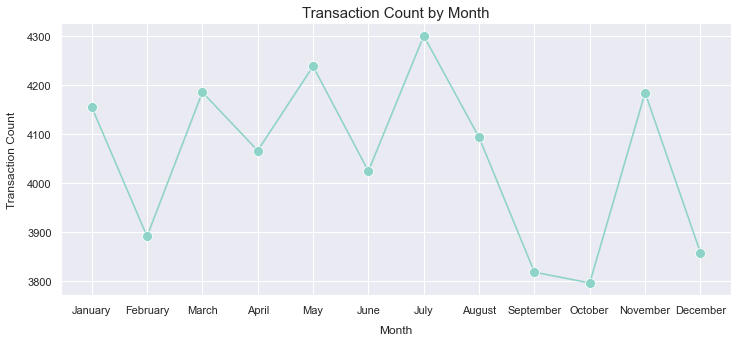

In [18]:
plt.figure(figsize=(12,5))
sns.lineplot(data=df2, x=df2["date"].dt.month_name(), y="transactioncount",marker='o',markersize=10)\
.set_title("Transaction Count by Month", fontsize=15)

#setting x and y labels
plt.margins(x=.05, y=.05) #changes width and height margins
plt.xlabel ("Month", labelpad=10)
plt.ylabel ("Transaction Count", labelpad=10)

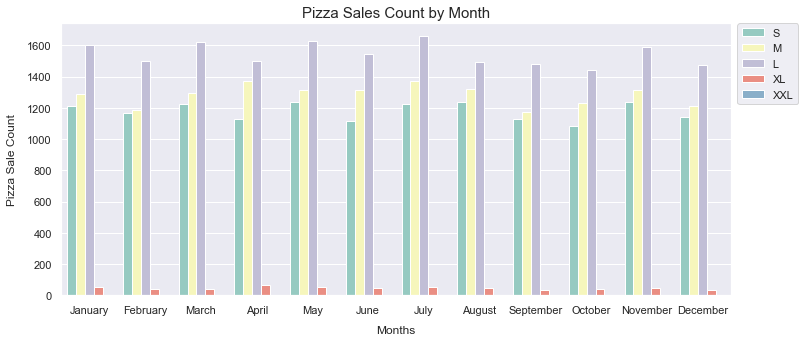

In [19]:
plt.figure(figsize=(12,5))
g = sns.barplot(y =df2['ordercount'], x= df2["date"].dt.month_name(), hue = df2['size'])

# Setting up the chart titles and legend spacing. 
g.margins(x=0.009, y=.05)
g.set_title("Pizza Sales Count by Month", fontsize=15)
g.set_xlabel ("Months", labelpad=10)
g.set_ylabel ("Pizza Sale Count", labelpad=10)
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper right', borderaxespad=0)

### Creating a new dataframe to view proudct category data

In [20]:
# sales by date
sm=df.groupby(df['category']).agg({'order_id':'count'}).reset_index().sort_values(by='category',ascending=True)

sm

,category,order_id
0,Chicken,10815
1,Classic,14579
2,Supreme,11777
3,Veggie,11449


In [21]:
# category sales by date 
# need the \ after agg argument to continue with the larger function

dc = df.groupby([df['date'],'category']).agg(categorysum= ('quantity','sum'))\
.reset_index().sort_values(by=['date','category'],ascending=True)

dc['date'] = pd.to_datetime(dc['date']) #change column to a datetime n64
dc.head(2)

,date,category,categorysum
0,2015-01-01,Chicken,913
1,2015-01-01,Classic,1257


### Creating new visualizations based on the two new dataframes

([<matplotlib.patches.Wedge at 0x1352c881d90>,
 [Text(0.9187270379912917, 0.7719719098929363, 'Chicken'),
  Text(-0.8343767580108711, 0.8624473466196463, 'Classic'),
  Text(-0.7449356566055259, -0.9407820510180317, 'Supreme'),
  Text(0.8863404309375861, -0.8089503325207145, 'Veggie')],
 [Text(0.5359241054949201, 0.45031694743754613, '22%'),
  Text(-0.4867197755063414, 0.503094285528127, '30%'),
  Text(-0.4345457996865567, -0.5487895297605184, '24%'),
  Text(0.5170319180469252, -0.47188769397041674, '24%')])

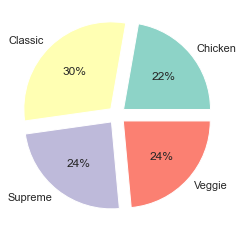

In [22]:
# Creating a pie chart to visualize the percentage different between the categories
plt.pie(data = sm, x = 'order_id',labels = 'category',autopct='%.0f%%',explode = (0.1, 0.1, 0.1, 0.1))

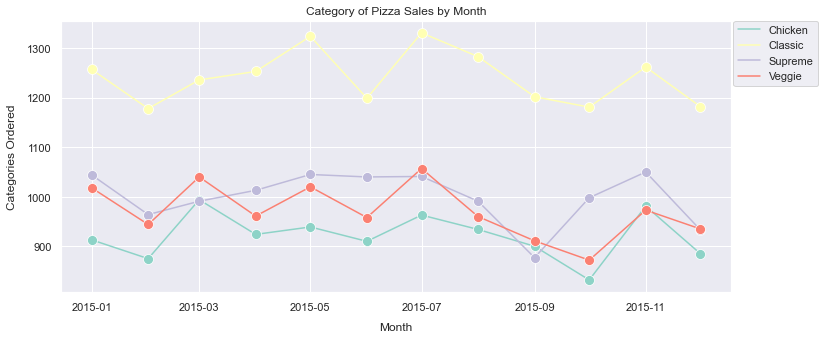

In [23]:
plt.figure(figsize=(12,5))
sns.lineplot(data=dc, x=dc["date"], y="categorysum",marker='o',markersize=10, hue = 'category')\
.set_title('Category of Pizza Sales by Month')


#setting x and y labels
plt.margins(x=.05, y=.05) #changes width and height margins
plt.xlabel ("Month", labelpad=10)
plt.ylabel ("Categories Ordered", labelpad=10)
plt.legend(bbox_to_anchor=(1.13, 1), loc='upper right', borderaxespad=0)

### This is the end of the notebook